<a href="https://colab.research.google.com/github/HMR1998/Laptop-Brands/blob/main/laptop_brand_model_dt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
import seaborn as sns

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
sns.set()

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn import metrics

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/Laptop_brands/model_data')

In [3]:
df.shape

(991, 16)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991 entries, 0 to 990
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   brand                     991 non-null    object 
 1   Model                     991 non-null    object 
 2   Price                     991 non-null    float64
 3   Rating                    991 non-null    int64  
 4   processor_brand           991 non-null    object 
 5   processor_tier            991 non-null    object 
 6   num_cores                 991 non-null    int64  
 7   num_threads               991 non-null    int64  
 8   ram_memory                991 non-null    int64  
 9   primary_storage_capacity  991 non-null    int64  
 10  gpu_type                  991 non-null    object 
 11  display_size              991 non-null    float64
 12  resolution_width          991 non-null    int64  
 13  resolution_height         991 non-null    int64  
 14  OS        

In [5]:
cat_data = ['brand', 'Model', 'processor_brand', 'processor_tier', 'gpu_type', 'OS']

label_encoder = LabelEncoder()

for col in cat_data:
  df[col + '_encoded'] = label_encoder.fit_transform(df[col])

In [6]:
df['price_in_log'] = df['Price'].apply(np.log)

In [7]:
df = df.drop(columns=cat_data)
df = df.drop(columns='number')

In [8]:
df.head()

,Price,Rating,num_cores,num_threads,ram_memory,primary_storage_capacity,display_size,resolution_width,resolution_height,brand_encoded,Model_encoded,processor_brand_encoded,processor_tier_encoded,gpu_type_encoded,OS_encoded,price_in_log
0,239.9,63,2,4,8,512,15.6,1920,1080,21,970,2,1,2,6,5.480222
1,359.9,67,4,8,16,1024,15.6,1920,1080,21,971,2,3,2,6,5.885826
2,511.0,73,6,12,8,512,15.6,1920,1080,10,620,0,12,1,6,6.236370
3,399.9,62,12,16,8,512,14.0,1920,1080,0,55,2,2,2,6,5.991215
4,285.8,62,4,8,8,512,15.6,1920,1080,14,838,0,11,2,6,5.655292


In [9]:
X = df.iloc[:,1:8]
y = df.iloc[:,15]

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=44)

parameters={"splitter":["best","random"],
            "max_depth" : [None,1,12],
           "min_samples_leaf":[1,9],
           "min_weight_fraction_leaf":[0.0, 0.1],
           "max_features":["log2", None],
           "max_leaf_nodes":[None,40],
            "ccp_alpha": [0.0, 0.003]}

dt = DecisionTreeRegressor(criterion='squared_error', ccp_alpha=0.00, max_depth=None,
                           min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None,
                           splitter='best', max_leaf_nodes=None)

In [98]:
dt.fit(X_train, y_train)

DecisionTreeRegressor()

In [99]:
# Predicting the target values of the test set
y_pred = dt.predict(X_val)

In [100]:
print('MAE:', metrics.mean_absolute_error(y_val,y_pred))
print('MSE:', metrics.mean_squared_error(y_val, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_val, y_pred)))

MAE: 0.20645208309193216
MSE: 0.07155100353092353
RMSE: 0.26749019333598667


In [ ]:
path = dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

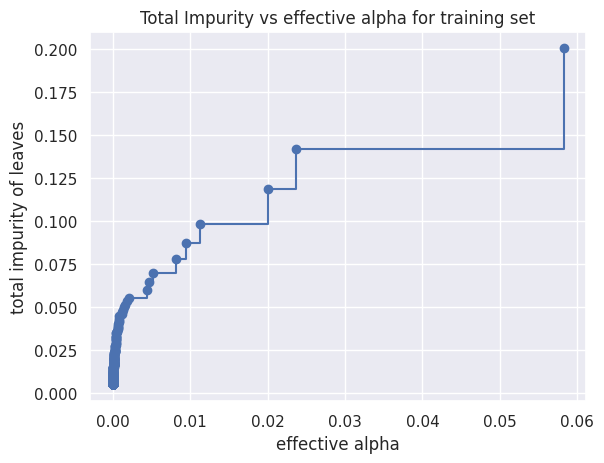

In [ ]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [108]:
tuning_model=GridSearchCV(dt,param_grid=parameters,scoring='neg_mean_squared_error', cv=5,verbose=1)

In [109]:
tuning_model.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'ccp_alpha': [0.0, 0.003], 'max_depth': [None, 1, 12],
                         'max_features': ['log2', None],
                         'max_leaf_nodes': [None, 40],
                         'min_samples_leaf': [1, 9],
                         'min_weight_fraction_leaf': [0.0, 0.1],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_squared_error', verbose=1)

In [110]:
tuning_model.best_params_

{'ccp_alpha': 0.0,
 'max_depth': 12,
 'max_features': None,
 'max_leaf_nodes': 40,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'splitter': 'random'}

In [111]:
hyper_pred = tuning_model.predict(X_val)

In [112]:
print('MAE:', metrics.mean_absolute_error(y_val,hyper_pred))
print('MSE:', metrics.mean_squared_error(y_val, hyper_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_val, hyper_pred)))

MAE: 0.19365311190984788
MSE: 0.059269400259901295
RMSE: 0.24345307609455522


<Axes: ylabel='Density'>

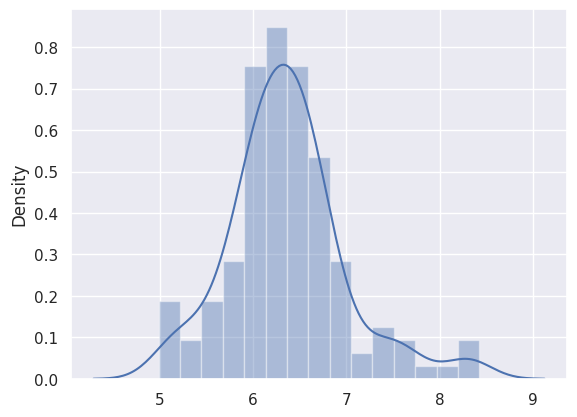

In [113]:
sns.distplot(y_pred)

<Axes: ylabel='Density'>

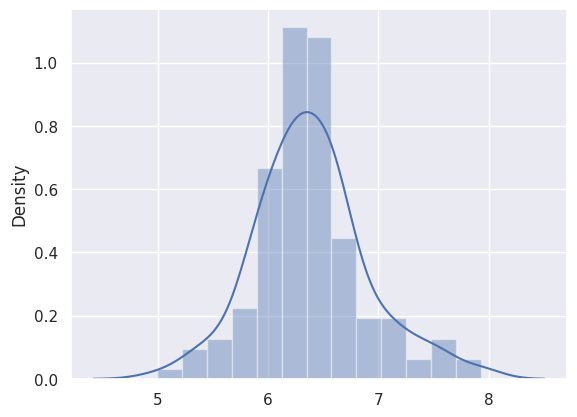

In [114]:
sns.distplot(hyper_pred)

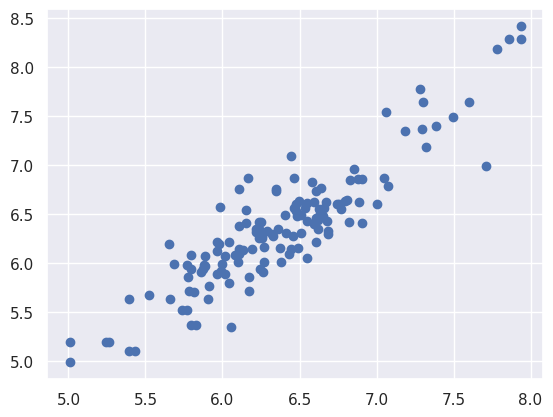

In [115]:
plt.scatter(y_val, y_pred)

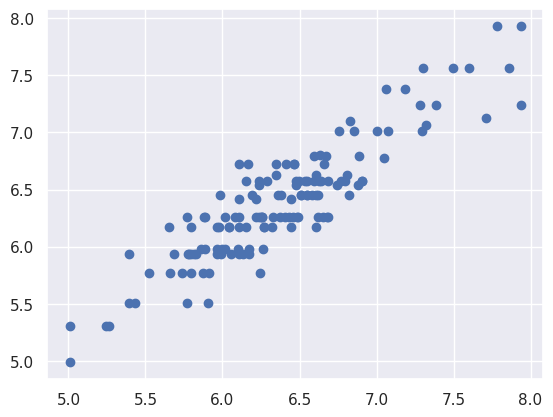

In [116]:
plt.scatter(y_val, hyper_pred)

In [117]:
test_pred = tuning_model.predict(X_test)

In [118]:
print('MAE:', metrics.mean_absolute_error(y_test,test_pred))
print('MSE:', metrics.mean_squared_error(y_test, test_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, test_pred)))

MAE: 0.19571527500855201
MSE: 0.07096017585017703
RMSE: 0.2663835127221222


In [ ]:
# class model_trainer:

#   def __init__ (self, model):
#     self.model = model

#   def training(self, X_train, y_train):
#     self.model.fit(X_train, y_train)

In [ ]:
# dt = DecisionTreeRegressor()

# dt_model = model_trainer(dt)